# Exploring Benefits of Pseudo-labeling for Fine-Grained Classification of Endangered Right Whales

This mini-project explores the added benefit, if any, of using pseudo-labels to create a model capable of fine-grained image classification. Iscen et al. (2019) present a method for propagating pseudo-labels to help classify images, and they suggest that “the less labeled data… available, the more pronounced the advantage of [their] proposed approach” [1]. They also show in their paper that their approach outperforms supervised approaches if the size of the training set in the supervised approach equals the number of labeled examples in the approach they propose. However, they acknowledge that they experimented with standard image data sets. Maybe the results in their paper could have been worse if they hadn’t used ResNet18 as their starting CNN architecture when training on Mini-ImageNet in their experiments, since ResNet18 was already trained on ImageNet to begin with? I decided to try their approach on an image data set that ResNet18 has not trained on and where different image classes have a lot more in common with each other to assess the benefit of pseudo-labeling.

## "Label Propagation for Deep Semi-Supervised Learning" by Iscen et al., 2019

Here is a visual summary of the method proposed by Iscen et al. (2019):
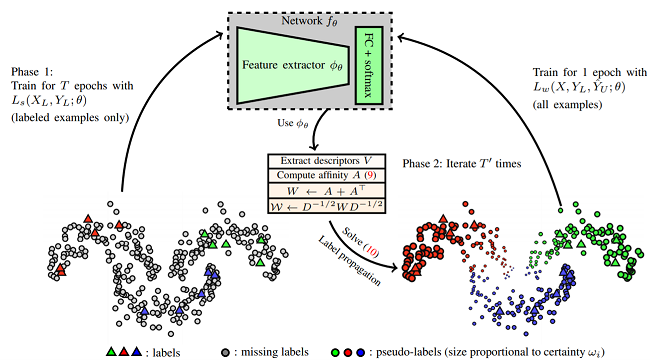

Given a set of labeled and unlabeled examples, the method aims to build a classifier that predicts the unlabeled examples and that generalizes to predict unlabeled examples outside of the given set. Phase 1 in the figure initializes a network, for example, with a pre-trained ResNet18, and trains it only with unlabeled examples. Phase 2 iterates through the cycle of using the network to make feature transformations of labeled and unlabeled examples, using the resulting feature vectors to construct a nearest neighbors graph for an affinity matrix, using the affinity matrix to generate pseudo-labels, and using pseudo-labels and labels from the labeled examples to train the network.

The authors also investigate the effect of integrating the Mean Teacher method into their method. However, Mean Teacher isn't directly related to the focus of this mini project on assessesing the benefit of pseudo-labels. Therefore, I did not use Mean Teacher.

Code for the paper can be found [here](https://github.com/ahmetius/LP-DeepSSL), and I'll refer to some parts of it later in this notebook.

## Non-standard Image Data Set
The image data set I used came from a [Kaggle competition on identifying individual right whales](https://www.kaggle.com/c/noaa-right-whale-recognition/overview). The National Oceanic and Atmospheric Administration (NOAA) curated this data set, and the images without meta data consist of full color, aerial photos of whales as their heads temporarily emerge from the ocean depths (see example below). Each individual whale has an ID to differentiate one whale from another, and the task for the Kaggle competition and for this project is to predict the ID of a whale in a photo.

example of a whale from data set:
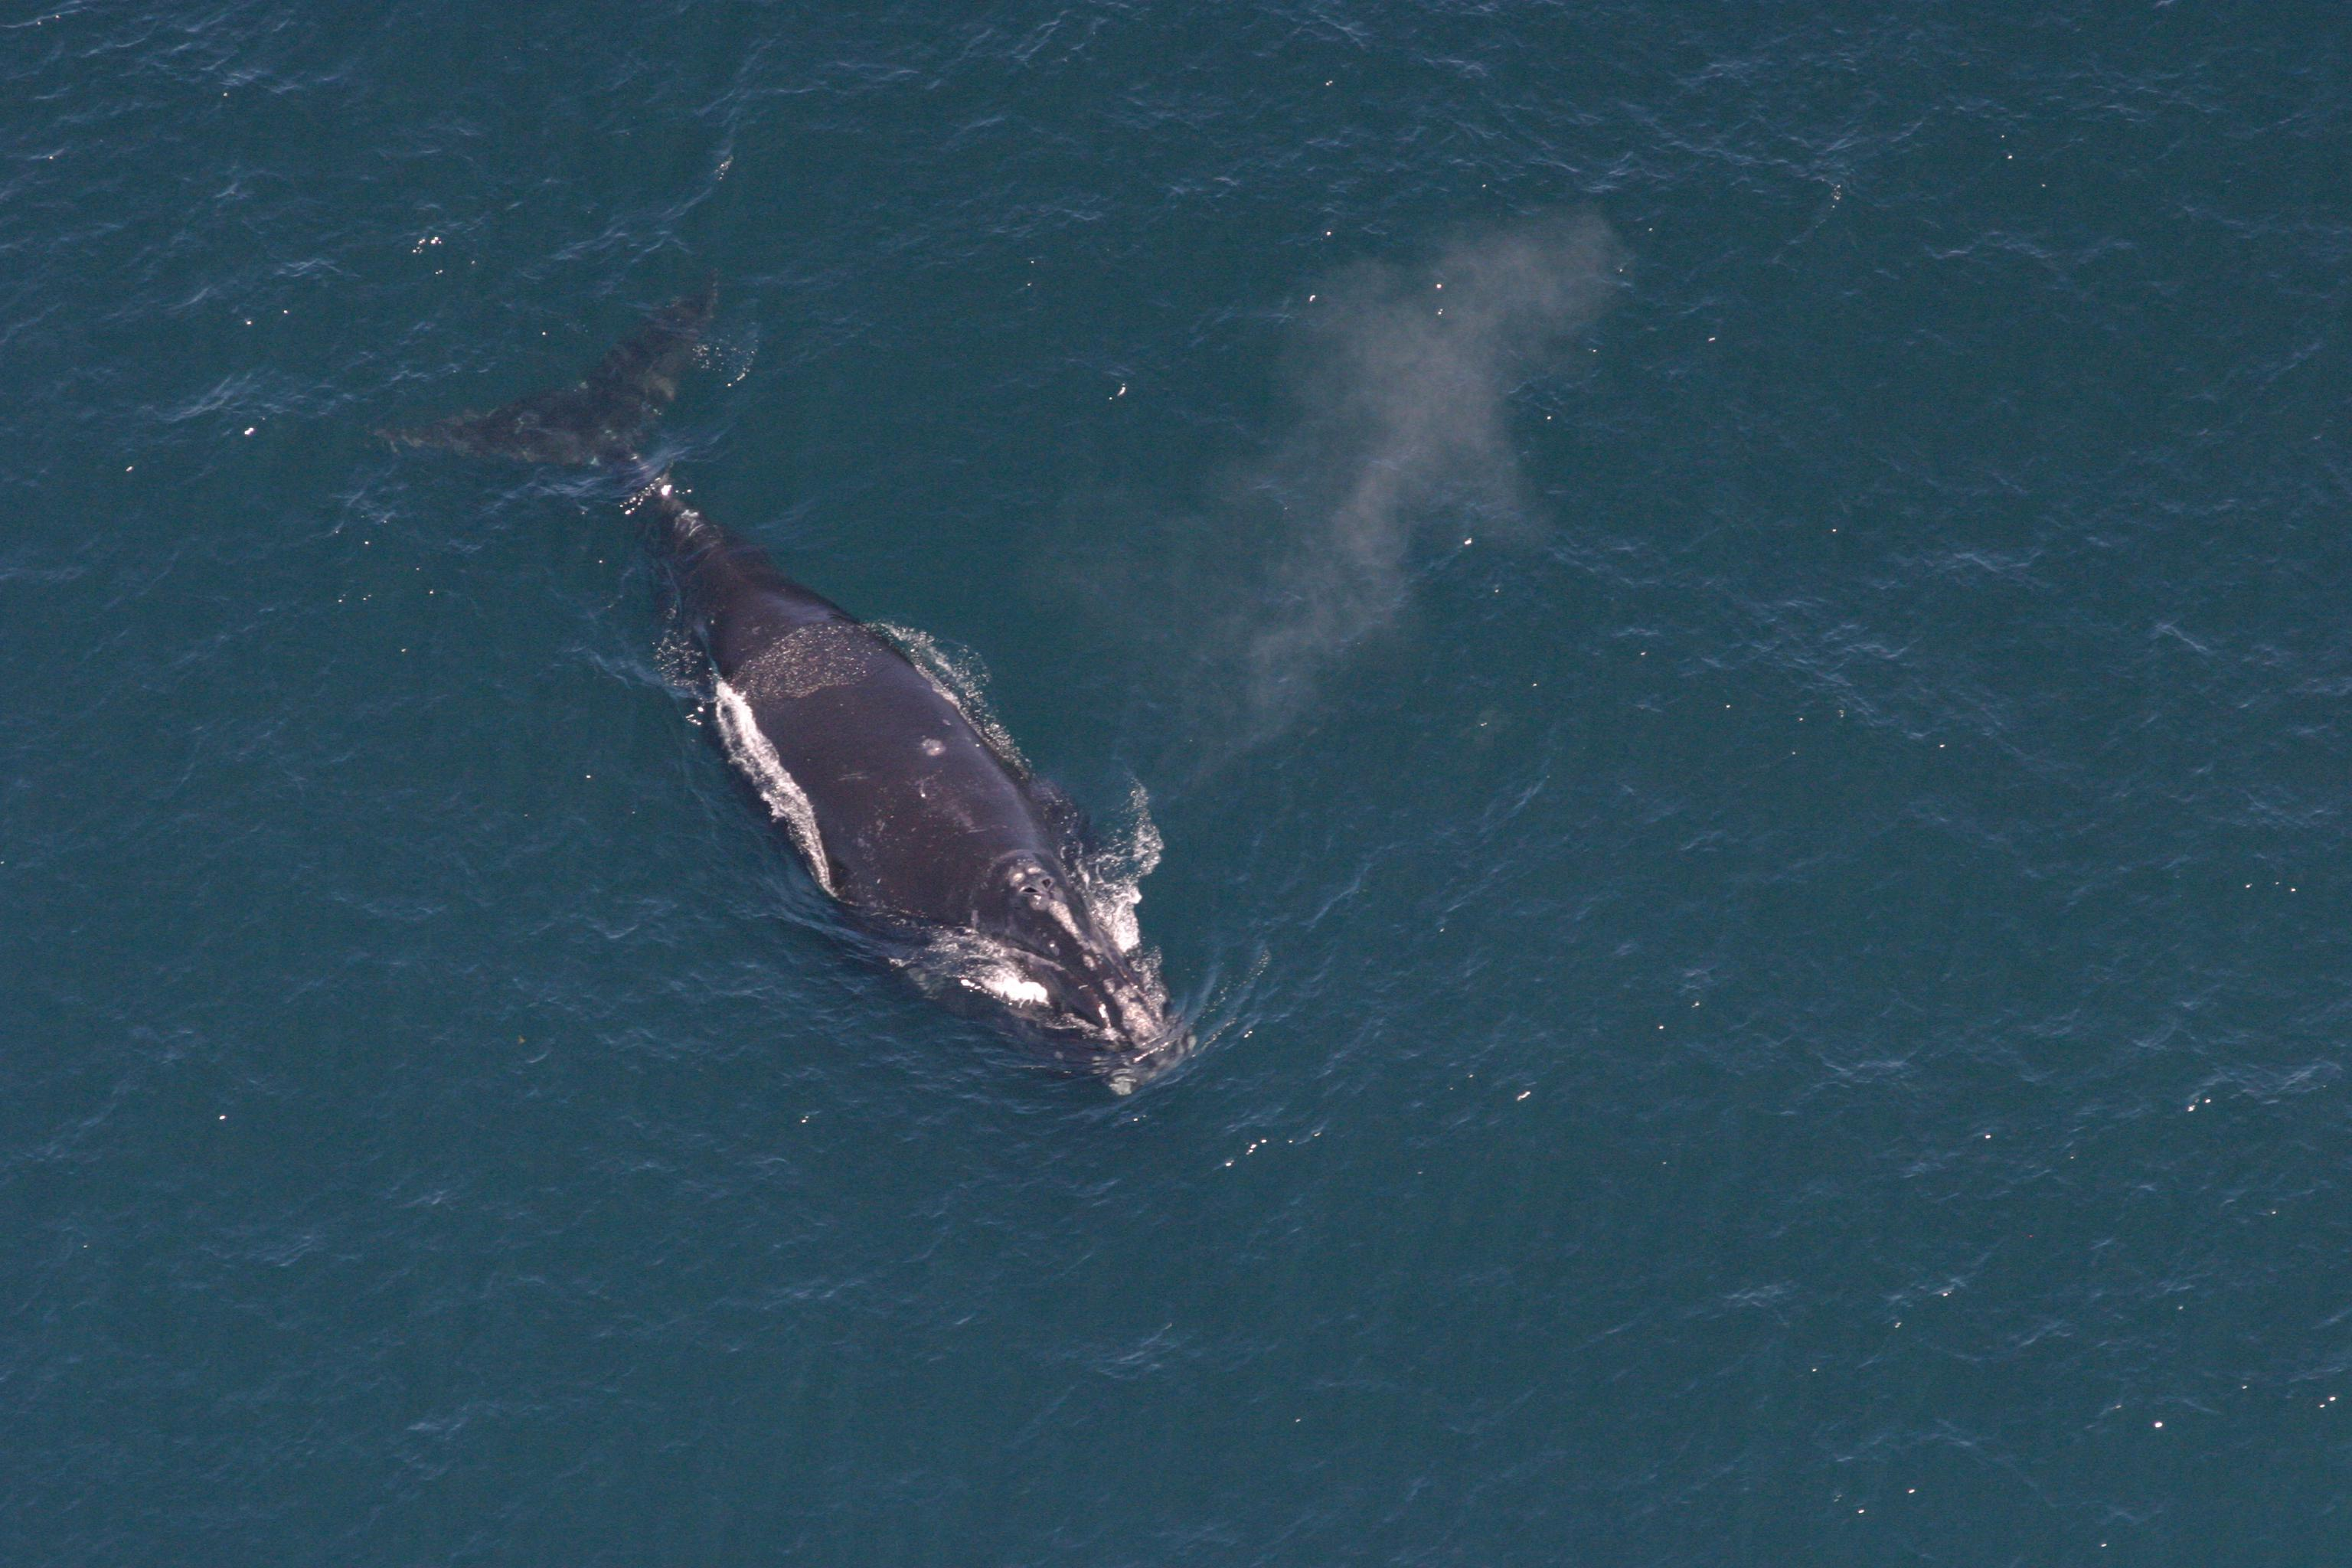

Other noteworthy information about the Kaggle data set are:

*   4543 photos in Kaggle's training set (should be 4544 images but 1 image was missing)
*   6925 photos in Kaggle's test set
*   Image dimensions vary
*   447 individuals, or classes
*   High class imbalance in Kaggle's training set, as shown below by Boguki et al., 2019

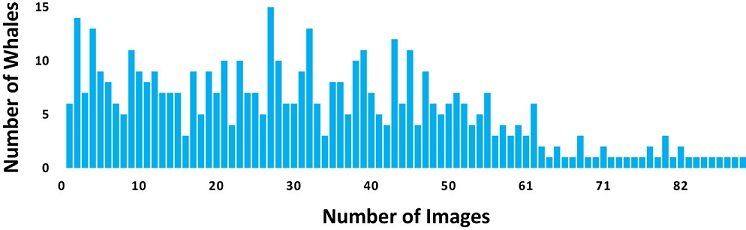

Aside from this data set exposing me to some realities of messy data, I thought that ResNet18 could train on this data set through transfer learning. Interestingly, the ImageNet data set for the Large Scale Visual Recognition Challenge in 2015 that ResNet trained on and performed well in [2] does [contain labels for whales](https://image-net.org/challenges/LSVRC/2015/browse-det-synsets.php) in general, and ResNet18 already has low-level features likely helpful for fine-grained classification. 

In addition, note that most whales have less than 50 images, the lowest number of labeled examples per class reported in experimental results for [1]. As a result, this data set may also help investigate the number of labeled examples necessary for a classifier to benefit from pseudo-labels, though I suspect this depends a lot on the accuracy of the labels and the distribution of noise in the input.


For the purposes of the competition, Kaggle's test set does not have whale IDs, so to make the most of the relatively small data set, these test images became the unlabeled examples. The infographic below shows the general composition of train and test sets for this mini project.

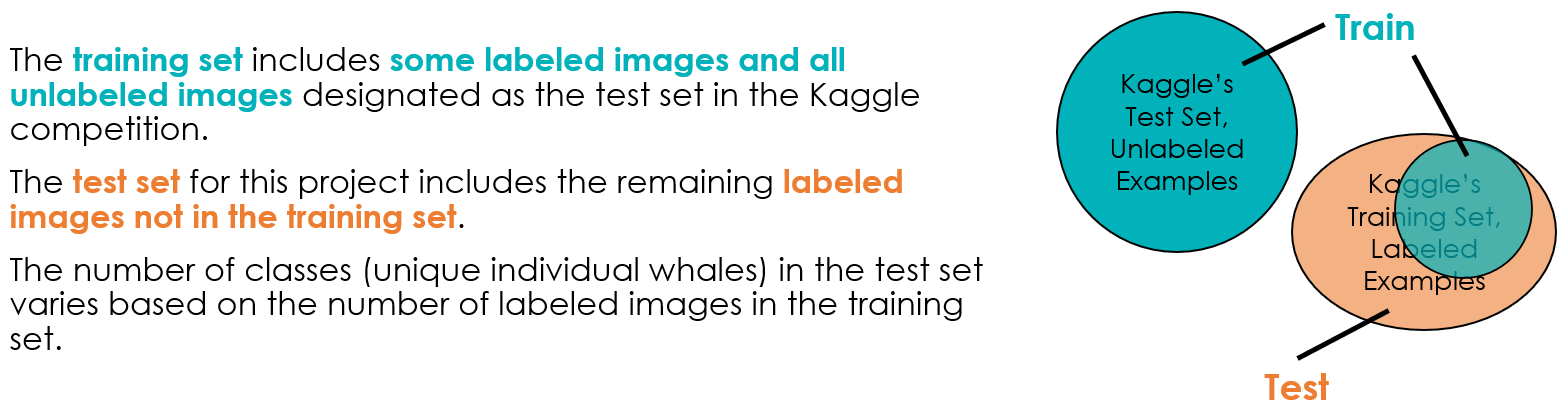

The part about the number of classes in the test set varying comes from the fact that class imbalance exists.

## Creating "Whale Passports"

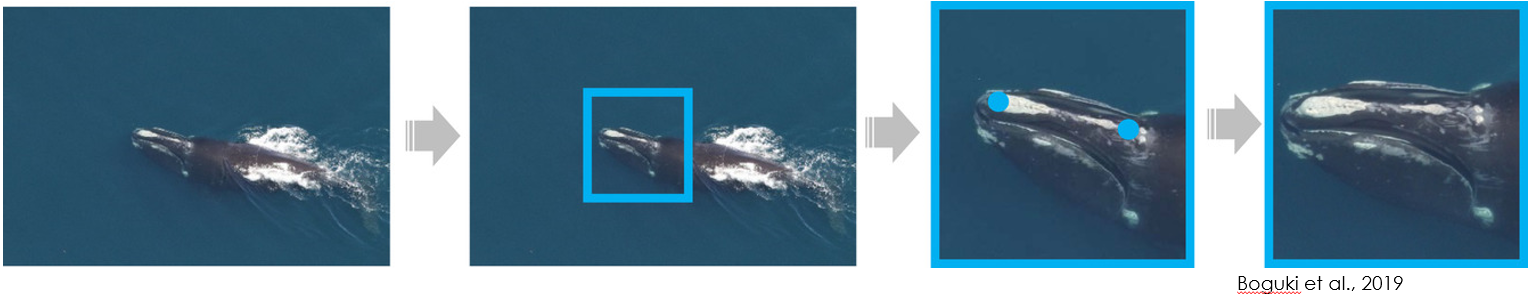

Callosity patterns on the whale's heads can help distinguish an individual whale from another. The winning Kaggle team [provided pixel coordinates of the blowhead and bonnet tip with respect to Kaggle's images](https://github.com/robibok/whales/blob/master/data/indygo_annos_all.json). To make the classifier's life easier, I used these coordinate points to create mugshots of the whales in each photo, making sure to align all whale heads in the same orientation. These whale passports make up the actual data set for this mini project and are provided when running code later in this notebook. Each passport is in full color and is 64 x 64 pixels.

Not all photos from the Kaggle data set could get preprocessed into whale passports. I ended up not preprocessing 4 photos from Kaggle's test set, due to the orientation of whales in these photos.

## Integrating the Data Set

The original implementation relies on all folders in train and test folders to represent classes and to have images organized in the following file structure:

```
train/class_x/xxx.ext
train/class_x/xxy.ext
train/class_x/xxz.ext
...
test/class_y/123.ext
test/class_y/nsdf3.ext
test/class_y/asd932_.ext
```

However, I was skeptical that this structure would work for the whale data set, since I wouldn't know what folder the unlabeled examples should go inside, without knowing their labels. The original set up certainly works for Iscen et al. (2019), since they can simply withhold some labels from images in the completely labeled CIFAR and Mini-ImageNet data sets to artifically create unlabeled examples.

The existing setup surprised me, because I would think that in real life, unlabeled examples truly have no labels, and the authors market their research toward use cases with limited labels, not for data that have enough labels just to have them withheld. Standard data sets like CIFAR and Mini-ImageNet have labels for all images, and Iscen et al. (2019) use these standard data sets in their experiments, which provided the added benefit of assessing the accuracy of pseudo-labels. For pseudo-labeling in this mini project, though, photos of whales from Kaggle's test set simply have no labels, so I unfortunately cannot know exactly how wrong (or how right) pseudo-labels are. The code will still evaluate the classifier every 30 or so iterations (compute the accuracy of predictions on the mini project's test set), which offers a rough idea of the accuracy and benefit of pseudo-labels. Spoiler alert--if accuracy decreases with pseudo-labels compared to without pseudo-labels, then pseudo-labels misdirect the training of the classifier. Below, I go over some quick fixes to files to adjust the code for my data set.

An example of the adjusted file structure of the whale data set from a clone of the GitHub repository for Iscen et al., 2019 is shown below. The data set is named "whalepassports". The subfolder named "unlabeled" contains the unlabeled examples.

```
├── data-local/images/whalepassports/
|  ├── train/
|    ├── unlabeled/
|      ├── w_0.jpg
|      ├── w_2.jpg
|      ├── w_4.jpg
|      ...
|    ├── whale_00195/
|      ├── w_676.jpg
|      ├── w_821.jpg
|      ├── w_2954.jpg
|      ...
|    ├── whale_02411/
|      ...
|    ├── whale_02608/
|      ...
|    ...
|  ├── test/
|    ├── whale_00195/
|      ...
|    ├── whale_02411/
|      ...
|    ├── whale_02608/
|      ...
|    ...
```





Several changes accomadate for the "unlabeled" folder. The revision to the code below makes it so that the folder of unlabeled examples does not count as a class. 

from original db_semisuper.py in the DatasetFolder class definition:


```
    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx
```


from revised db_semisuper.py in the DatasetFolder class definition:
```
    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir() and d.name != "unlabeled"]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx
```

However, making the folder of unlabeled examples not count as a class also means changing the initialization of the data set, because in the original code, the data set will not include images from folders that do not represent a class. -1 stands for an unlabeled example in the implementation, so I made the following change to the same file:

from original db_semisuper.py:

```
def make_dataset(dir, class_to_idx, extensions):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(class_to_idx.keys()):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if has_file_allowed_extension(fname, extensions):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images
```

revised db_semisuper.py:

```
def make_dataset(dir, class_to_idx, extensions):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(class_to_idx.keys()):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if has_file_allowed_extension(fname, extensions):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    if "unlabeled" in os.listdir(dir):
        d = os.path.join(dir, "unlabeled")
        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if has_file_allowed_extension(fname, extensions):
                    path = os.path.join(root, fname)
                    item = (path, -1)
                    images.append(item)

    return images
```
The following changes in db_semisuper.py and train_stage2.py report the accuracy of pseudo-labels only when labels are withheld.

from original db_semisuper.py:

```
def update_plabels(self, X, k = 50, max_iter = 20):
        ...
        # Compute the accuracy of pseudolabels for statistical purposes
        correct_idx = (p_labels == labels)
        acc = correct_idx.mean()
        ...
        return acc
```

revised db_semisuper.py:
```
def update_plabels(self, X, k = 50, max_iter = 20):
        ...
        # Compute the accuracy of pseudolabels for statistical purposes, if possible
        acc = -1
        if -1 not in labels:
            correct_idx = (p_labels == labels)
            acc = correct_idx.mean()
            assert acc >= 0
        ...
        return acc
```

from original train_stage2.py:

```
def main():
    ...
    for epoch in range(args.start_epoch, args.epochs):
        # Extract features and update the pseudolabels
        print('Extracting features...')
        feats,labels = extract_features(train_loader_noshuff, model, isMT = args.isMT)
        sel_acc = train_data.update_plabels(feats, k = args.dfs_k, max_iter = 20)
        print('selection accuracy: %.2f' % (sel_acc))
        ...
    ...
```

revised original train_stage2.py:

```
def main():
    ...
    for epoch in range(args.start_epoch, args.epochs):
        # Extract features and update the pseudolabels
        print('Extracting features...')
        feats,labels = extract_features(train_loader_noshuff, model, isMT = args.isMT)
        sel_acc = train_data.update_plabels(feats, k = args.dfs_k, max_iter = 20)
        if sel_acc != -1:
            print('selection accuracy: %.2f' % (sel_acc))
        ...
    ...
```

The next set of changes make the program recognize the "whalepassports" data set and specify parameter values. For example, the following change in load_args() defined in helpers.py sets the parameters for the whale data set to be the same as the one Iscen et al., 2019 used when training on the Mini-ImageNet data set:


```
    elif args.dataset == "miniimagenet" or args.dataset == "whalepassports":
        args.train_subdir = 'train'
        args.evaluation_epochs = 30

        args.batch_size = 128
        args.lr = 0.2
        args.test_batch_size = args.batch_size

        args.epochs = 180
        args.lr_rampdown_epochs = 210
        args.ema_decay = 0.97

        args.logit_distance_cost = 0.01
        args.consistency = 100.0
        args.weight_decay = 2e-4
        args.labels = '%s/labels/%s/%d_balanced_labels/%d.txt' % (label_dir,args.dataset,args.num_labeled,args.label_split)
        args.arch = 'resnet18'
```

Next, for convenience, in mean-teacher/cli.py, I changed the default data set from 'cifar10' to 'whalepassports' in create_parser():

original mean-teacher/cli.py:
```
    parser.add_argument('--dataset', metavar='DATASET', default='cifar10',
                        choices=datasets.__all__,
                        help='dataset: ' +
                            ' | '.join(datasets.__all__) +
                            ' (default: imagenet)')
```

revised mean-teacher/cli.py:


```
    parser.add_argument('--dataset', metavar='DATASET', default='whalepassports',
                        choices=datasets.__all__,
                        help='dataset: ' +
                            ' | '.join(datasets.__all__) +
                            ' (default: imagenet)')
```

Finally, in mean-teacher/datasets.py, images get converted into tensors required for Pytorch libraries that the code depends on. The hard-coded values for mean_pix and std_pix are the same values Iscen et al., 2019 used to find the mean_pix and std_pix of the Mini-ImageNet data set.


```
@export
def whalepassports(isTwice=True):
    mean_pix = [x/255.0 for x in [120.39586422,  115.59361427, 104.54012653]]
    std_pix = [x/255.0 for x in [70.68188272,  68.27635443,  72.54505529]]

    channel_stats = dict(mean=mean_pix,
                         std=std_pix)

    if isTwice:
        train_transformation = data.TransformTwice(transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(**channel_stats)
        ]))
    else:
        train_transformation = data.TransformOnce(transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(**channel_stats)
        ]))

    eval_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(**channel_stats)
    ])

    data_dir = 'data-local/images/whalepassports'

    print("Using whale-passports from", data_dir)

    return {
        'train_transformation': train_transformation,
        'eval_transformation': eval_transformation,
        'datadir': data_dir,
        'num_classes': 447
    }
```

Note that if I remove all classes with less than the desired number of labeled examples per class, I need to determine and change the value of 'num_classes' returned. More on this below.


## Creating Train-Test Splits
For each whale, I randomly selected some number of labeled examples for the training set and wrote the image name with their corresponding whale ID to a text file required by the code for Iscen et al., 2019. The remaining images belong in the test set. An example of the file structure of the text files is shown below:

```
├── data-local/labels/whalepassports/
|  ├── 1_balanced_labels/
|    ├── 0.txt
|    ├── 1.txt
|    ├── 2.txt
|    ...
|  ├── 5_balanced_labels/
|    ├── 0.txt
|    ├── 1.txt
|    ├── 2.txt
|    ...
```

The # in '#_balanced_labels' stands for the number of labeled examples per individual whale. The # in '#.txt' stands for the (# + 1)-th split. I needed to know both numbers to run the code properly. In this project, I only used 5_balanced_labels/0.txt. 

The method and implementation as it currently stands does not accomodate for unbalanced classes among the labeled examples, which meant removing all whales with less than the desired number of labeled examples from the folder data-local/images/whalepassports. If I had more time for this project, I would look into revising the implementation to accomodate for unbalanced classes among the labeled examples.

## Evaluating the Benefit of Pseudo-labels for Whale Data Set

After investigating what needed to be changed and spending some time debugging some issues associated with these changes and minor differences in syntax between versions of Pytorch, I was ready to run the code at least once all the way through without any errors. 

This code depends on a GPU. In Google Colab, go to Runtime > Change runtime type, and select "GPU" in the Hardward accelerator dropdown menu. Hit Save.

Install and import all required packages.

In [ ]:
import numpy as np
import scipy
import torch

In [ ]:
# necessary for nearest neighbor computations
!pip install faiss-gpu

     |████████████████████████████████| 89.4MB 34kB/s 


Import files.

In [ ]:
!git clone https://github.com/21hyin/right-whale-LP-DeepSSL

/content
Cloning into 'right-whale-LP-DeepSSL'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 141 (delta 54), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (141/141), 10.99 MiB | 12.35 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
!mkdir right-whale-LP-DeepSSL/data-local/images/whalepassports
!unzip right-whale-LP-DeepSSL/data-local/images/whalepassports_with_all_unlabeled.zip -d right-whale-LP-DeepSSL/data-local/images

Streaming output truncated to the last 5000 lines.
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_5097.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_5098.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_51.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_510.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_5101.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_5106.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_5108.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_511.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/train/unlabeled/w_5112.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/tr

In [ ]:
%cd right-whale-LP-DeepSSL

/content/right-whale-LP-DeepSSL


### Label Propagation for Deep SSL with 5 Labeled Examples Per Class

Due to the lack of accomodations for class imbalance, I removed all classes from the data set that have less than 6 labeled examples. The first five labeled examples are for training, and the remaining labeled examples are for test such that each class trained has at least one test image. This arrangement should be OK for a preliminary assessment. The model outputs top-1 and top-5 accuracy, or, in other words, the accuracy of the most and top five most confident predictions from the model, respectively. Other metrics could be used, but I stuck with accuracy out of convenience and to start off simple. For the purposes of this mini project, I will use accuracy to assess the benefit of pseudo-labels.

Data set after removing classes with < 6 labels:
*   321 classes
*   Train: 5 labeled examples per class (1605 labeled examples), 6924 unlabeled examples
*   Test: 2564 labeled examples


Running each phase of the model produces lots of output irrelevant to the purpose of this project, but for clarity, here's some information on what the output means. *If you're in a hurry, read up to the first bullet point and skip the rest.*

Example output:

```
Epoch: [0][0/12]LR 0.2000 (0.2000)	Time 1.025 (1.025)	Data 0.413 (0.413)	Class 5.7704 (5.7704)	Prec@1 0.000 (0.000)	Prec@5 2.344 (2.344)
...
Evaluating the primary model:
  * Prec@1 11.193	Prec@5 18.916
```

*   **Prec@1** and **Prec@5** stand for top-1 and top-5 accuracy, respectively. *This output is most relevant to the project.* These get reported during training and evaluation. Unless I'm mistaken, the results stand for accuracy,  not precision. It's unclear why the implementation prints out these results as "precision" when the name of the function involved in computing it is literally named accuracy() in helpers.py. Precision and accuracy have different meanings, so it's important not to use these terms interchangeably. 

Brief information about the remaining output:

*   The number in the first bracket stands for the number of epochs that the model has already trained on.
*   Not 100% sure, but I think in the second bracket, the number left of the slash refers to the number of batches in stochastic gradient descent already processed, and the number right of the slash is the number of batches.
*   LR means learning rate, or step size
*   Time refers to the time to train on a batch, and Data is data loading time
*   Class refers to cross-entropy







Note that rerunning the model below may produce slightly different accuracies due to the use of random number generators in the implementation.

Phase 1 (~3 minutes)

*   Trains on labeled examples only
*   Saves the network parameters leading to the best-performing model to start off with for Phase 2

In [ ]:
!python train_stage1.py --exclude-unlabeled=True --num-labeled=5 --gpu-id='0' --label-split=0 --isMT=False --isL2=True --dataset='whalepassports'

data-local/labels/whalepassports/5_balanced_labels/0.txt


Running: Num labels: 5, Split: 0, GPU: 0


Using whale-passports from data-local/images/whalepassports
Epoch: [0][0/12]LR 0.2000 (0.2000)	Time 0.937 (0.937)	Data 0.285 (0.285)	Class 5.7692 (5.7692)	Prec@1 0.000 (0.000)	Prec@5 2.344 (2.344)
Epoch: [1][0/12]LR 0.2000 (0.2000)	Time 0.237 (0.237)	Data 0.201 (0.201)	Class 5.7618 (5.7618)	Prec@1 0.781 (0.781)	Prec@5 3.125 (3.125)
Epoch: [2][0/12]LR 0.2000 (0.2000)	Time 0.247 (0.247)	Data 0.202 (0.202)	Class 5.7486 (5.7486)	Prec@1 0.781 (0.781)	Prec@5 5.469 (5.469)
Epoch: [3][0/12]LR 0.1999 (0.1999)	Time 0.233 (0.233)	Data 0.195 (0.195)	Class 5.7266 (5.7266)	Prec@1 4.688 (4.688)	Prec@5 14.062 (14.062)
Epoch: [4][0/12]LR 0.1998 (0.1998)	Time 0.239 (0.239)	Data 0.198 (0.198)	Class 5.7151 (5.7151)	Prec@1 14.062 (14.062)	Prec@5 28.906 (28.906)
Epoch: [5][0/12]LR 0.1997 (0.1997)	Time 0.231 (0.231)	Data 0.187 (0.187)	Class 5.6758 (5.6758)	Prec@1 48.438 (48.438)	Prec@5 67.188 (67.188)
Epoch:

Phase 2 (~45 minutes)


*   Trains on labeled and unlabeled examples

In [ ]:
!python train_stage2.py --labeled-batch-size=31 --num-labeled=5 --gpu-id='0' --label-split=0 --isMT=False --isL2=True --dataset='whalepassports'



Running: Num labels: 5, Split: 0, GPU: 0


Using whale-passports from data-local/images/whalepassports
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 * Prec@1 15.601	Prec@5 23.245
Resuming from:models/whalepassports_5_split_0_isL2_1/best.ckpt
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [0][0/71]LR 0.2000 (0.2000)	Time 0.742 (0.742)	Data 0.269 (0.269)	Class 1.0199 (1.0199)	Prec@1 71.875 (71.875)	Prec@5 92.969 (92.969)
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [1][0/71]LR 0.2000 (0.2000)	Time 0.299 (0.299)	Data 0.261 (0.261)	Class 1.4752 (1.4752)	Prec@1 39.062 (39.062)	Prec@5 63.281 (63.281)
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [2][0/71]LR 0.2000 (0.2000)	Time 0.311 (0.311)	Data 0.272 (0.272)	Class 2.442

#### Analysis of Preliminary Results

In Phase 1, as the number of epochs increased, the accuracy on the training set increased, while the accuracy on the test set eventually plateaued and even slightly decreased a little bit. In Phase 2, as the number of epochs increased, the accuracy on the training set increased, while the accuracy on the test set slightly decreased. Training on the small number of labeled examples may have resulted in the rampant overfitting. At the same time, the overfitting shouldn't completely rule out the fact that pseudo-labels seem to lower accuracy by several percentage points compared to the training only on labeled examples. The table below displays the best results obtained from both phases. The pseudo-labels here didn't make up for any portion of low performance from overfitting caused by the lack of labeled examples. Pseudo-labeling actually hurt performance.


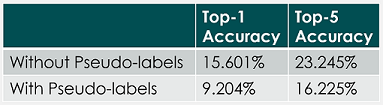

Given the high ratio of unlabeled examples to labeled examples, might lowering this ratio help reduce the noise created from pseudo-labels when updating network parameters, while maximizing whatever potential benefits come from pseudo-labels? To find out, I ran the model twice with different ratios of unlabeled to labeled examples: first with a 1:1 ratio of unlabeled to labeled examples and second with about a 1:2 ratio of unlabeled to labeled examples. Random sampling determined which unlabeled examples to keep and which to remove from the training set.

#### 1:1 ratio of unlabeled to labeled examples (~20 minutes)



In [ ]:
%cd ..
!rm -r right-whale-LP-DeepSSL/data-local/images/whalepassports
!mkdir right-whale-LP-DeepSSL/data-local/images/whalepassports
!unzip right-whale-LP-DeepSSL/data-local/images/whalepassports_with_equal_unlabeled.zip -d right-whale-LP-DeepSSL/data-local/images

Streaming output truncated to the last 5000 lines.
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_50021/w_3554.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_50021/w_3724.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_50021/w_4215.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_50021/w_4687.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_50021/w_5156.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_50021/w_6357.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_50021/w_7167.jpg  
   creating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_51195/
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_51195/w_1652.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/t

In [ ]:
%cd right-whale-LP-DeepSSL
!python train_stage2.py --labeled-batch-size=31 --num-labeled=5 --gpu-id='0' --label-split=0 --isMT=False --isL2=True --dataset='whalepassports'

/content/right-whale-LP-DeepSSL


Running: Num labels: 5, Split: 0, GPU: 0


Using whale-passports from data-local/images/whalepassports
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 * Prec@1 15.601	Prec@5 23.245
Resuming from:models/whalepassports_5_split_0_isL2_1/best.ckpt
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [0][0/16]LR 0.2000 (0.2000)	Time 0.710 (0.710)	Data 0.239 (0.239)	Class 0.9205 (0.9205)	Prec@1 76.562 (76.562)	Prec@5 97.656 (97.656)
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [1][0/16]LR 0.2000 (0.2000)	Time 0.289 (0.289)	Data 0.249 (0.249)	Class 0.9014 (0.9014)	Prec@1 86.719 (86.719)	Prec@5 95.312 (95.312)
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [2][0/16]LR 0.2000 (0.2000)	Time 0.301 (0.301

#### ~1:2 ratio of unlabeled to labeled examples (<15 minutes)

In [ ]:
%cd ..
!rm -r right-whale-LP-DeepSSL/data-local/images/whalepassports
!mkdir right-whale-LP-DeepSSL/data-local/images/whalepassports
!unzip right-whale-LP-DeepSSL/data-local/images/whalepassports_with_half_unlabeled.zip -d right-whale-LP-DeepSSL/data-local/images

Streaming output truncated to the last 5000 lines.
   creating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_1923.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_214.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_3936.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_4100.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_5602.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_5666.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_6272.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/test/whale_24730/w_7965.jpg  
  inflating: right-whale-LP-DeepSSL/data-local/images/whalepassports/te

In [ ]:
%cd right-whale-LP-DeepSSL
!python train_stage2.py --labeled-batch-size=31 --num-labeled=5 --gpu-id='0' --label-split=0 --isMT=False --isL2=True --dataset='whalepassports'

/content/right-whale-LP-DeepSSL


Running: Num labels: 5, Split: 0, GPU: 0


Using whale-passports from data-local/images/whalepassports
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 * Prec@1 15.601	Prec@5 23.245
Resuming from:models/whalepassports_5_split_0_isL2_1/best.ckpt
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [0][0/8]LR 0.2000 (0.2000)	Time 0.711 (0.711)	Data 0.240 (0.240)	Class 0.8832 (0.8832)	Prec@1 71.094 (71.094)	Prec@5 96.875 (96.875)
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [1][0/8]LR 0.2000 (0.2000)	Time 0.301 (0.301)	Data 0.261 (0.261)	Class 0.9169 (0.9169)	Prec@1 89.844 (89.844)	Prec@5 99.219 (99.219)
Extracting features...
Updating pseudo-labels...
kNN Search done in 0 seconds
Epoch: [2][0/8]LR 0.2000 (0.2000)	Time 0.292 (0.292)	D

### Summary of Preliminary Results

Acknowledging overfitting, the table below displays all of the better results obtained from both phases and after trying different ratios of unlabeled to labeled examples in Phase 2. The ~4.3 : 1 ratio is the ratio of using all unlabeled examples available, and results for this and for Phase 1 come from the first run of the model in this notebook (and copied from the previous table).

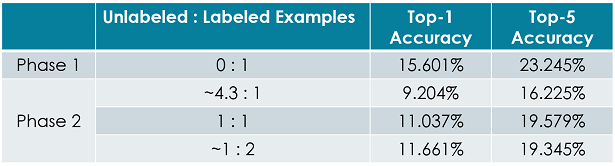

Adding unlabeled examples from this data set into the training process for fine-grained classification seems to reduce accuracy. Reducing the ratio of unlabeled to labeled examples seems to improve accuracy, suggesting that pseudo-labels added unhelpful noise into the training process. It's unclear why performance remained about the same between the 1 : 1 and 1 : 2 ratios, but the initial reduction from using all unlabeled examples to using an equal number of unlabeled and labeled examples improves accuracy by a few percentage points. Maybe I needed to make the ratio something like 1 : 4 to better see the improvement in performance.

Factors other than overfitting may contribute to the ineffectiveness of pseudo-labels and low accuracy. For example, training on the full ResNet18 architecture might not have been the best choice, since the higher-level layers likely incorporated information specific to the ImageNet data set not found in this whale data set. Instead, it may be better to remove the higher-level layers and train the existing linear classifier using activations responsible for detecting low-level features from earlier in the network.

## Takeaways From This Mini Project

1.   Be prepared to devote time towards understanding existing code of published techniques before applying these techniques to new or non-standard data sets. 
2.   Published results on standardized data sets can serve as a good first step due to the standardization, but more work needs to be done to say anything about these results in relation to tasks and data sets beyond the scope of what's been published. I would like to see more development and adoption of theory-driven ways of understanding why and when pseudo-labeling could work for a specific data set.




## Future Directions

Given that pseudo-labeling doesn't seem to suit the whale data set, perhaps other methods such as few-shot learning better suit this classification task. Few-shot learning by [4] uses no pseudo-labels and makes bigger promises of using a lot less labeled data than methods relying on pseudo-labels to classify images suggest. Transfer learning with components of pre-trained ResNet18, may help better compare how differently few-shot and pseudo-labeling perform, cases where both perform well, and cases where both don’t perform well. While [4] does not use ResNet18, I can adapt [existing GitHub repositories on similar tasks](https://github.com/daisukelab/protonet-fine-grained-clf) that use [4] to my needs. I considered few-shot learning for potentially better success on this project, but, after looking through existing code and documentation for both few-shot and pseudo-labeling, I concluded that I would learn more overall within the time-frame of this project by going with pseudo-labeling. Looking forward to exploring few-shot learning on my own time, though, especially since we discussed [4] in class.  

## Acknowledgements

Thanks Bert and Sasha for a great semester.

## Helpful References

[1] Iscen A, Tolias G, Avrithis Y, Chum O. (2019) Label Propagation for Deep Semi-Supervised Learning. 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Long Beach, CA, USA, 2019, pp. 5065-5074, doi: 10.1109/CVPR.2019.00521.

[2] He K, Zhang X, Ren S, Sun J. (2016) Deep Residual Learning for Image Recognition. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.

[3] Bogucki R, Cygan M, Khan CB, Klimek M, Milczek JK, Mucha M. (2019) Applying deep learning to right whale photo identification. Conserv Biol. 33(3):676-684. doi:10.1111/cobi.13226

[4] Snell J, Swersky K, Zemel RS. (2017) Prototypical networks for few-shot learning. Advances in Neural Information Processing Systems 30: Annual Conference on Neural Information Processing Systems 2017, 4-9 December 2017, Long Beach, CA, USA, 2017, pp. 4080-4090.
